In [1]:
import numpy as np
from utils.slam_helpers import transform_to_frame,transformed_params2depthplussilhouette,transformed_params2rendervar
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from scripts.main_SurgeSplat import deform_gaussians, setup_camera
import torch
import os
from PIL import Image

System Paths:
/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM
/media/thesis_ssd/anaconda/envs/endogslam/lib/python310.zip
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/lib-dynload

/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages


In [2]:
intrinsics = torch.tensor([[199.6883,   0.0000, 166.3290],
        [  0.0000, 249.4753, 170.4058],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')
w2c = torch.tensor([[ 1.0000e+00,  6.5711e-11,  2.3283e-10,  0.0000e+00],
        [-3.1832e-11,  1.0000e+00, -7.4115e-21,  0.0000e+00],
        [-9.2644e-22,  2.9104e-11,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

cam = setup_camera(336,336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=True)




In [3]:
params_np = np.load('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/experiments/EndoNerf cutting_deform/cutting_deform/params.npz')
params={}
for key in params_np.keys():
    params[key] = torch.tensor(params_np[key]).cuda()

In [4]:
params

{'means3D': tensor([[-0.8277, -0.6788,  0.9937],
         [-0.8221, -0.6782,  0.9929],
         [-0.8170, -0.6781,  0.9928],
         ...,
         [ 0.8250,  0.6521,  0.9884],
         [ 0.8302,  0.6523,  0.9888],
         [ 0.8365,  0.6534,  0.9904]], device='cuda:0'),
 'rgb_colors': tensor([[0.4591, 0.2327, 0.2647],
         [0.4609, 0.2375, 0.2697],
         [0.4570, 0.2325, 0.2657],
         ...,
         [0.7550, 0.4738, 0.2952],
         [0.7407, 0.4762, 0.2829],
         [0.7441, 0.4852, 0.2881]], device='cuda:0'),
 'unnorm_rotations': tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]], device='cuda:0'),
 'logit_opacities': tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]], device='cuda:0'),
 'log_scales': tensor([[-5.4206],
         [-5.4213],
         [-5.4215],
         ...,
         [-5.4259],
      

In [5]:

def deform_gaussians(params,time,deform_grad):

    if deform_grad:
        weights = params['deform_weights']
        stds = params['deform_stds']
        biases = params['deform_biases']
    else:
        weights = params['deform_weights'].detach()
        stds = params['deform_stds'].detach()
        biases = params['deform_biases'].detach()

    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1) # Nx10 gaussians deformations
    deform_xyz = deform[:,:3]
    deform_rots = deform[:,3:7]
    deform_scales = deform[:,7:10]
    # print(f'xyz: {torch.sum(deform_xyz)}')
    # print(torch.sum(deform_rots).item())
    # print(torch.sum(deform_scales).item())
    xyz = params['means3D']+deform_xyz
    rots = params['unnorm_rotations']+deform_rots
    scales = params['log_scales']#+deform_scales

    return xyz,rots,scales


for id in range(params['cam_unnorm_rots'].shape[-1]):
    local_means,local_rots,local_scales = deform_gaussians(params,id,deform_grad = True)


    #  print(torch.sum(local_means-params['means3D']))

    transformed_pts = transform_to_frame(local_means,params,id,False,False)





    # Initialize Render Variables
    rendervar = transformed_params2rendervar(params, transformed_pts,local_rots,local_scales)
    print(local_scales.max())
    rv_store = {}
    for key in rendervar.keys():
        rv_store[key] = rendervar[key].cpu().detach()
        local_means_store = local_means.cpu()
        local_scales_store = local_rots.cpu()
        local_rots_store = local_rots.cpu()
        transformed_pts_store = transformed_pts.cpu()



    #  rendervar['means3D'].retain_grad()
    depth_sil_rendervar = transformed_params2depthplussilhouette(params, w2c,
                                            transformed_pts,local_rots,local_scales)


    #RGB Rendering

    rendervar['means2D'].retain_grad()
    im, radius, _ = Renderer(raster_settings=cam)(**rendervar)
    # variables['means2D'] = rendervar['means2D'] # Gradient only accum from colour render for densification
    img = Image.fromarray((im.permute(1,2,0).cpu().detach().numpy()*255).astype(np.uint8))
    os.makedirs(f'./eval_plots/plots/',exist_ok=True)
    img.save(f'./eval_plots/plots/{id}.png')

    print(local_means)


tensor(-5.4164, device='cuda:0')
tensor([[-0.4771, -0.3372,  1.5417],
        [-1.1294, -0.5532,  1.0645],
        [-0.8951, -0.5821,  0.9796],
        ...,
        [ 0.9867,  0.7222,  0.6031],
        [ 1.2408,  0.8769,  0.8648],
        [ 0.8620,  0.6847,  0.9434]], device='cuda:0')
tensor(-5.4164, device='cuda:0')
tensor([[-0.5747, -0.3809,  1.5349],
        [-1.0335, -0.6328,  1.0200],
        [-0.8530, -0.6368,  0.9903],
        ...,
        [ 0.9289,  0.6705,  0.6389],
        [ 1.1755,  0.8223,  0.9449],
        [ 0.8380,  0.6625,  0.9824]], device='cuda:0')
tensor(-5.4164, device='cuda:0')
tensor([[-0.7464, -0.5347,  1.3475],
        [-0.8855, -0.6744,  0.9954],
        [-0.8218, -0.6734,  0.9927],
        ...,
        [ 0.8514,  0.6529,  0.8041],
        [ 0.9830,  0.7123,  0.9853],
        [ 0.8365,  0.6539,  0.9902]], device='cuda:0')
tensor(-5.4164, device='cuda:0')
tensor([[-0.8161, -0.6402,  1.1468],
        [-0.8304, -0.6782,  0.9930],
        [-0.8172, -0.6780,  0.9928]

In [6]:
torch.exp(torch.tensor(59))

tensor(4.2012e+25)

In [7]:
rv_store['scales'].max()

tensor(0.0044)

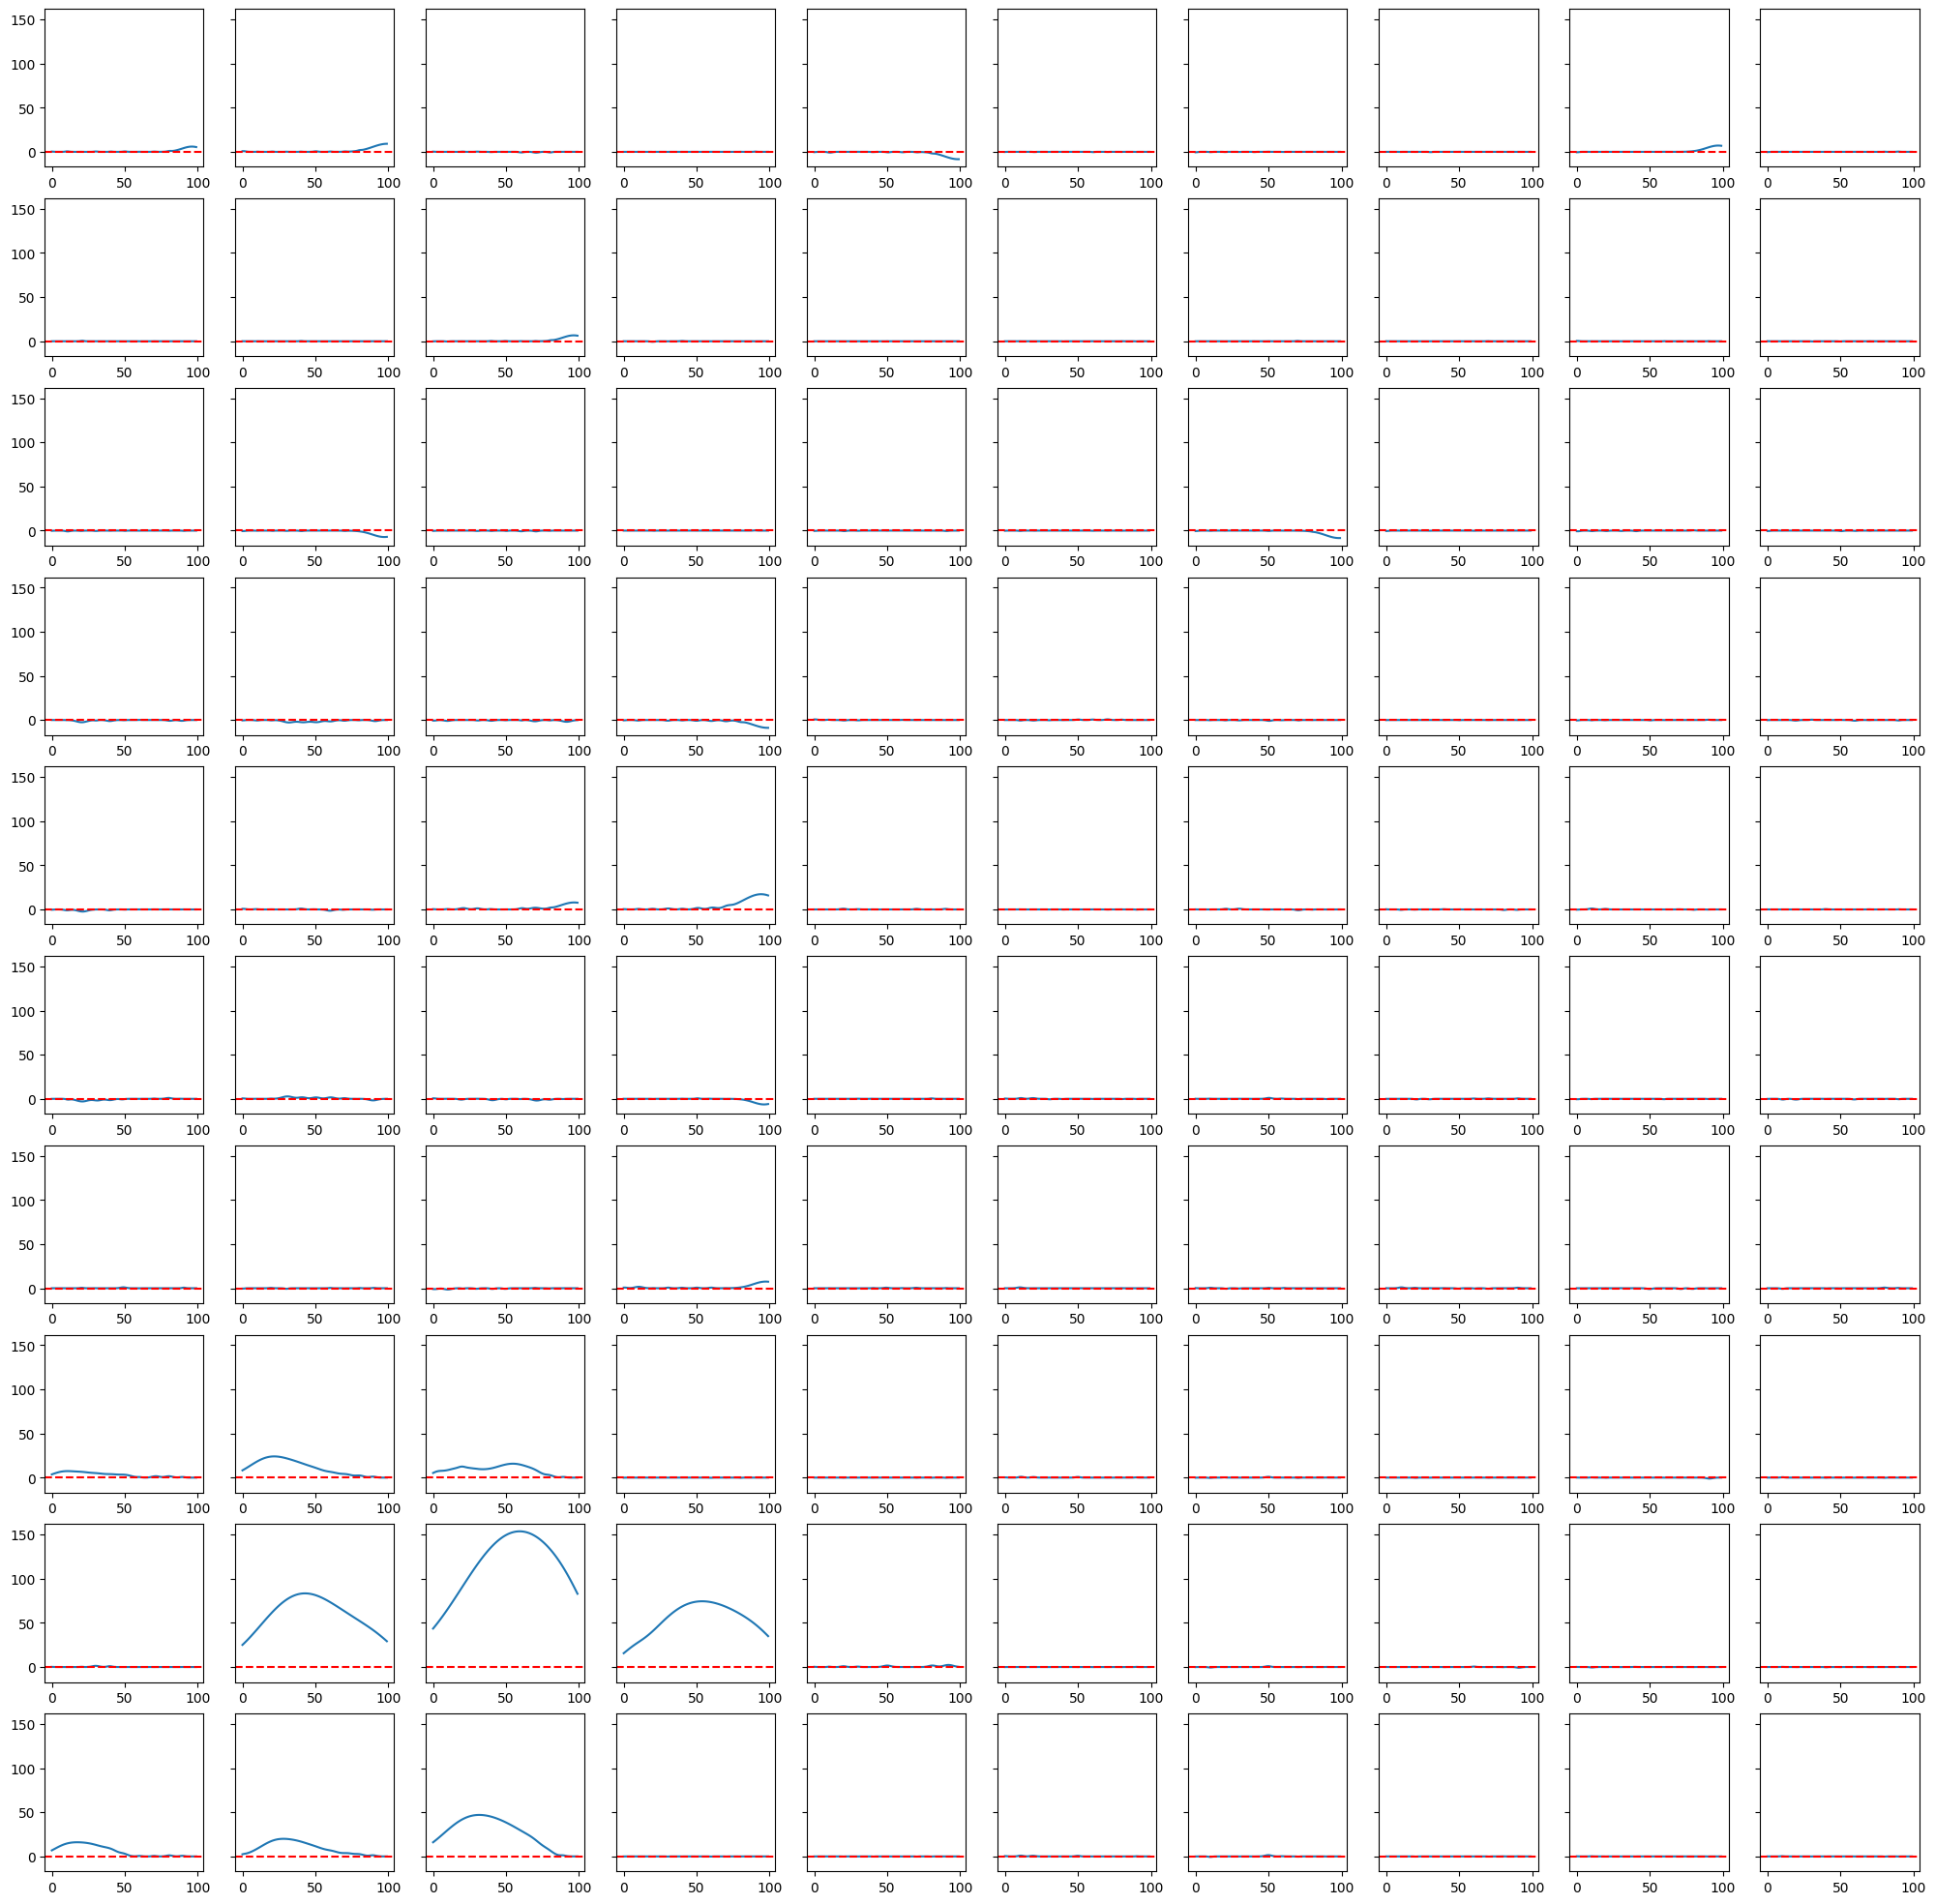

In [8]:
import matplotlib.pyplot as plt
weights =   params['deform_weights'].cpu().detach()
biases =    params['deform_biases'].cpu().detach()
stds =      params['deform_stds'].cpu().detach()

deforms = []
deformsx1 = []
for time in range(100):
    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
    deforms.append(deform) # Nx10 gaussians deformations
    deformsx1.append(deform[0,0])
fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
for i in range(10):
    for ii in range(10):
        ax[ii,i].plot([deforms[idx][i+91720//3,ii] for idx in range(len(deforms))])
        ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [9]:
torch.argmin(params['deform_stds'])

tensor(3085494, device='cuda:0')

In [10]:
params['deform_stds'].view(-1).shape

torch.Size([11289600])

In [11]:
maxs = np.array([deform.max() for deform in deforms])
maxs.max()

153.72293